In [1]:
import copy
import os
import sys
from pathlib import Path

import numpy as np
from qutip.solver.floquet import progress_bars
import torch
from pulser import Pulse, Register, Sequence
from pulser.devices import MockDevice
from pulser_diff.backend import TorchEmulator
from pyqtorch.utils import SolverType
from torch import Tensor
import json
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py as h5

In [2]:
sys.path.append("../..")

In [3]:
from source.NAHEA_CNN import NAHEA_CNN_1

In [4]:
# load data from sin dataset
data_save_dir = Path("../../data") / "sin"
data_save_path_train = data_save_dir / "train.h5"
data_save_path_test = data_save_dir / "test.h5"

with h5.File(data_save_path_train, "r") as f:
    X_train = f["X"][:].squeeze(2)
    y_train = f["y"][:]

with h5.File(data_save_path_test, "r") as f:
    X_test = f["X"][:].squeeze(2)
    y_test = f["y"][:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4000, 18)
y_train shape: (4000, 1)
X_test shape: (1000, 18)
y_test shape: (1000, 1)


In [5]:
n_train = 150
n_test = 500 # testing is much faster than training
X_train = X_train[:n_train]
y_train = y_train[:n_train]
X_test = X_test[:n_test]
y_test = y_test[:n_test]

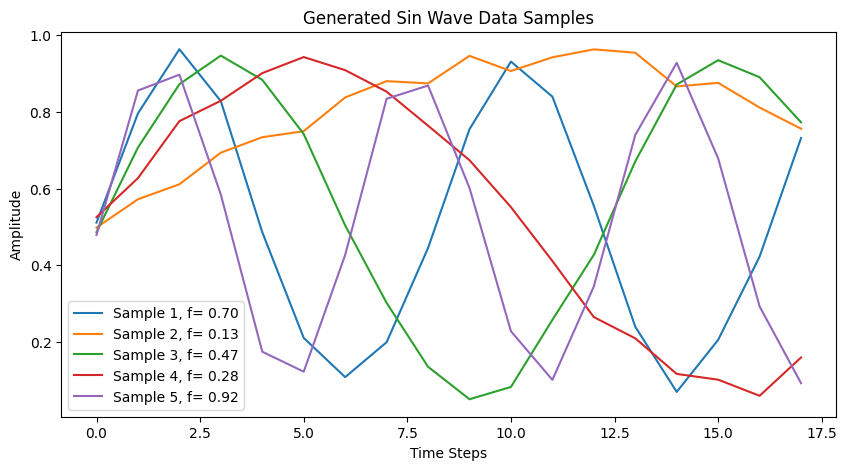

In [6]:
# plot some data
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(X_train[i], label=f"Sample {i+1}, f= {y_train[i][0]:.2f}")
plt.title("Generated Sin Wave Data Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [7]:
seq_len = X_train.shape[1]
hparams = {
    "n_features": (n_features := 5),  # =1D kernel size = number of qubits
    "sampling_rate": 0.2,
    "protocol": "min-delay",
    "n_ancilliary_qubits": (n_ancilliary_qubits := 0), # not implemented
    "input_length": seq_len,
    "stride": 3,  # stride for the convolution
    "output_dim": 1,  # output dimension of the final FC NN
    "hidden_layers_dims": [10, 5],
}

sep = 7.0
parameters = {
    # separation of 7 between the qubits
    "positions": [[sep * i - (sep * 2), 0] for i in range(n_features)],
    "local_pulses_omega_1": [0.5, 1.0, 1.5, 1.0, 0.5],
    "local_pulses_delta_1": [0.0] * n_features,
    "global_pulse_omega_1": 1.0,
    "global_pulse_delta_1": 0.0,
    "global_pulse_omega_2": 0.5,
    "global_pulse_delta_2": 0.0,
    "global_pulse_duration": 100,
    "local_pulse_duration": 80,
    "embed_pulse_duration": 80,
}


NAHEA_CNN = NAHEA_CNN_1(
    hparams=hparams, parameters=parameters, name="NAHEA_CNN_2"
)

# set some parameters to not require gradients. They didn't change much last time
NAHEA_CNN._parameters["positions"].requires_grad = False
NAHEA_CNN._parameters["local_pulses_delta_1"].requires_grad = False
NAHEA_CNN._parameters["global_pulse_delta_1"].requires_grad = False
NAHEA_CNN._parameters["global_pulse_delta_2"].requires_grad = False

Final FC NN: Sequential(
  (0): Linear(in_features=5, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)
Adding parameter 0.weight to model
Adding parameter 0.bias to model
Adding parameter 2.weight to model
Adding parameter 2.bias to model
Adding parameter 4.weight to model
Adding parameter 4.bias to model


In [8]:
# train the model
batch_size = 16
epochs = 20
loss_hist = []
# MSE loss function
loss_fn = torch.nn.MSELoss()
NAHEA_CNN.train()
print(f"{NAHEA_CNN.parameters()}")
optimizer = torch.optim.Adam(
    [param for _, param in NAHEA_CNN.parameters().items() if param.requires_grad],
    lr=0.01,
    weight_decay=1e-5,
)
params_hist = [copy.deepcopy(NAHEA_CNN.parameters())]
for epoch in range(epochs):
    # shuffle X_train and y_train
    idxs = np.arange(len(X_train))
    idxs = np.random.permutation(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]

    epoch_losses = []
    for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        x_batch = torch.tensor(X_train[i : i + batch_size], dtype=torch.float64)
        y_batch = torch.tensor(
            y_train[i : i + batch_size], dtype=torch.float64
        ).squeeze(1)
        batch_out = [NAHEA_CNN(xx) for xx in x_batch]
        predicted = torch.stack([bo["output"] for bo in batch_out])
        loss = loss_fn(predicted.squeeze(1), y_batch)
        tqdm.write(
            f"Batch {i // batch_size + 1} loss: {loss.item():.4f}, "
            f"RMSE: {np.sqrt(loss.item()):.4f}"
        )
        epoch_losses.append(loss.item())
        loss_hist.append(loss.item())
        loss.backward()
        optimizer.step()
        params_hist.append(copy.deepcopy(NAHEA_CNN.parameters()))
    epoch_loss = np.mean(epoch_losses)
    tqdm.write(f"Epoch {epoch+1} train loss: {epoch_loss}")
loss_hist = np.array(loss_hist)
print(f"Final loss: {loss_hist[-1]}")
print(f"Final loss (RMSE): {np.sqrt(loss_hist[-1])}")

{'positions': tensor([[-14.,   0.],
        [ -7.,   0.],
        [  0.,   0.],
        [  7.,   0.],
        [ 14.,   0.]]), 'local_pulses_omega_1': tensor([0.5000, 1.0000, 1.5000, 1.0000, 0.5000], requires_grad=True), 'local_pulses_delta_1': tensor([0., 0., 0., 0., 0.]), 'global_pulse_omega_1': tensor(1., requires_grad=True), 'global_pulse_delta_1': tensor(0.), 'global_pulse_omega_2': tensor(0.5000, requires_grad=True), 'global_pulse_delta_2': tensor(0.), 'global_pulse_duration': tensor(100.), 'local_pulse_duration': tensor(80.), 'embed_pulse_duration': tensor(80.), 'conv_params': tensor([0.0332, 0.0367, 0.0541, 0.0100, 0.0195, 0.0300, 0.0260, 0.0343, 0.0724,
        0.0432, 0.0666, 0.0478, 0.0474, 0.0709, 0.0560, 0.0499, 0.0512, 0.0213,
        0.0820, 0.0422, 0.0693, 0.0374, 0.0558, 0.0108, 0.0531, 0.0436, 0.0603,
        0.0712, 0.0427, 0.0348, 0.0379, 0.0219], dtype=torch.float64,
       requires_grad=True), '0.weight': Parameter containing:
tensor([[ 0.2841, -0.4780,  0.0122, -0

Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.2372, RMSE: 0.4870
Batch 2 loss: 0.1842, RMSE: 0.4292
Batch 3 loss: 0.0949, RMSE: 0.3081
Batch 4 loss: 0.0869, RMSE: 0.2949
Batch 5 loss: 0.1264, RMSE: 0.3555
Batch 6 loss: 0.0531, RMSE: 0.2305
Batch 7 loss: 0.0508, RMSE: 0.2253
Batch 8 loss: 0.0485, RMSE: 0.2202
Batch 9 loss: 0.0648, RMSE: 0.2546
Batch 10 loss: 0.1685, RMSE: 0.4105
Epoch 1 train loss: 0.11154221089515051


Epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.1099, RMSE: 0.3315
Batch 2 loss: 0.0953, RMSE: 0.3087
Batch 3 loss: 0.0664, RMSE: 0.2576
Batch 4 loss: 0.0597, RMSE: 0.2443
Batch 5 loss: 0.0664, RMSE: 0.2577
Batch 6 loss: 0.0732, RMSE: 0.2705
Batch 7 loss: 0.0837, RMSE: 0.2892
Batch 8 loss: 0.0257, RMSE: 0.1604
Batch 9 loss: 0.0608, RMSE: 0.2465
Batch 10 loss: 0.0356, RMSE: 0.1886
Epoch 2 train loss: 0.06766153712473418


Epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0906, RMSE: 0.3010
Batch 2 loss: 0.0938, RMSE: 0.3062
Batch 3 loss: 0.0679, RMSE: 0.2605
Batch 4 loss: 0.0484, RMSE: 0.2199
Batch 5 loss: 0.0580, RMSE: 0.2408
Batch 6 loss: 0.0344, RMSE: 0.1855
Batch 7 loss: 0.0404, RMSE: 0.2011
Batch 8 loss: 0.0515, RMSE: 0.2269
Batch 9 loss: 0.0521, RMSE: 0.2283
Batch 10 loss: 0.0587, RMSE: 0.2422
Epoch 3 train loss: 0.059571977177937344


Epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0513, RMSE: 0.2264
Batch 2 loss: 0.0338, RMSE: 0.1837
Batch 3 loss: 0.0391, RMSE: 0.1977
Batch 4 loss: 0.0458, RMSE: 0.2141
Batch 5 loss: 0.0449, RMSE: 0.2118
Batch 6 loss: 0.0370, RMSE: 0.1923
Batch 7 loss: 0.0358, RMSE: 0.1892
Batch 8 loss: 0.0627, RMSE: 0.2503
Batch 9 loss: 0.0680, RMSE: 0.2608
Batch 10 loss: 0.0344, RMSE: 0.1854
Epoch 4 train loss: 0.04526538863047009


Epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0391, RMSE: 0.1977
Batch 2 loss: 0.0420, RMSE: 0.2049
Batch 3 loss: 0.0323, RMSE: 0.1798
Batch 4 loss: 0.0280, RMSE: 0.1673
Batch 5 loss: 0.0494, RMSE: 0.2224
Batch 6 loss: 0.0440, RMSE: 0.2097
Batch 7 loss: 0.0368, RMSE: 0.1919
Batch 8 loss: 0.0378, RMSE: 0.1945
Batch 9 loss: 0.0394, RMSE: 0.1985
Batch 10 loss: 0.0439, RMSE: 0.2094
Epoch 5 train loss: 0.03927179798807644


Epoch 6:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0397, RMSE: 0.1992
Batch 2 loss: 0.0299, RMSE: 0.1729
Batch 3 loss: 0.0287, RMSE: 0.1694
Batch 4 loss: 0.0320, RMSE: 0.1789
Batch 5 loss: 0.0303, RMSE: 0.1739
Batch 6 loss: 0.0213, RMSE: 0.1458
Batch 7 loss: 0.0412, RMSE: 0.2030
Batch 8 loss: 0.0301, RMSE: 0.1735
Batch 9 loss: 0.0310, RMSE: 0.1762
Batch 10 loss: 0.0217, RMSE: 0.1472
Epoch 6 train loss: 0.030576805678950585


Epoch 7:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0235, RMSE: 0.1533
Batch 2 loss: 0.0143, RMSE: 0.1197
Batch 3 loss: 0.0360, RMSE: 0.1897
Batch 4 loss: 0.0215, RMSE: 0.1466
Batch 5 loss: 0.0255, RMSE: 0.1598
Batch 6 loss: 0.0285, RMSE: 0.1688
Batch 7 loss: 0.0220, RMSE: 0.1483
Batch 8 loss: 0.0125, RMSE: 0.1117
Batch 9 loss: 0.0204, RMSE: 0.1428
Batch 10 loss: 0.0162, RMSE: 0.1273
Epoch 7 train loss: 0.022042906115099393


Epoch 8:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0166, RMSE: 0.1288
Batch 2 loss: 0.0211, RMSE: 0.1452
Batch 3 loss: 0.0134, RMSE: 0.1158
Batch 4 loss: 0.0198, RMSE: 0.1408
Batch 5 loss: 0.0127, RMSE: 0.1127
Batch 6 loss: 0.0149, RMSE: 0.1222
Batch 7 loss: 0.0102, RMSE: 0.1011
Batch 8 loss: 0.0170, RMSE: 0.1305
Batch 9 loss: 0.0160, RMSE: 0.1266
Batch 10 loss: 0.0050, RMSE: 0.0710
Epoch 8 train loss: 0.014688156934582326


Epoch 9:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0114, RMSE: 0.1069
Batch 2 loss: 0.0160, RMSE: 0.1263
Batch 3 loss: 0.0086, RMSE: 0.0930
Batch 4 loss: 0.0082, RMSE: 0.0904
Batch 5 loss: 0.0066, RMSE: 0.0812
Batch 6 loss: 0.0075, RMSE: 0.0866
Batch 7 loss: 0.0111, RMSE: 0.1052
Batch 8 loss: 0.0082, RMSE: 0.0903
Batch 9 loss: 0.0153, RMSE: 0.1235
Batch 10 loss: 0.0093, RMSE: 0.0964
Epoch 9 train loss: 0.010206483360943918


Epoch 10:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0055, RMSE: 0.0743
Batch 2 loss: 0.0091, RMSE: 0.0952
Batch 3 loss: 0.0075, RMSE: 0.0866
Batch 4 loss: 0.0087, RMSE: 0.0931
Batch 5 loss: 0.0071, RMSE: 0.0843
Batch 6 loss: 0.0051, RMSE: 0.0712
Batch 7 loss: 0.0042, RMSE: 0.0644
Batch 8 loss: 0.0048, RMSE: 0.0694
Batch 9 loss: 0.0047, RMSE: 0.0688
Batch 10 loss: 0.0004, RMSE: 0.0203
Epoch 10 train loss: 0.005705704059916882


Epoch 11:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0032, RMSE: 0.0568
Batch 2 loss: 0.0047, RMSE: 0.0688
Batch 3 loss: 0.0052, RMSE: 0.0722
Batch 4 loss: 0.0050, RMSE: 0.0705
Batch 5 loss: 0.0032, RMSE: 0.0567
Batch 6 loss: 0.0035, RMSE: 0.0592
Batch 7 loss: 0.0051, RMSE: 0.0712
Batch 8 loss: 0.0038, RMSE: 0.0613
Batch 9 loss: 0.0026, RMSE: 0.0508
Batch 10 loss: 0.0018, RMSE: 0.0420
Epoch 11 train loss: 0.003802787028160085


Epoch 12:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0028, RMSE: 0.0532
Batch 2 loss: 0.0025, RMSE: 0.0499
Batch 3 loss: 0.0033, RMSE: 0.0575
Batch 4 loss: 0.0029, RMSE: 0.0540
Batch 5 loss: 0.0026, RMSE: 0.0507
Batch 6 loss: 0.0013, RMSE: 0.0364
Batch 7 loss: 0.0029, RMSE: 0.0543
Batch 8 loss: 0.0040, RMSE: 0.0633
Batch 9 loss: 0.0017, RMSE: 0.0411
Batch 10 loss: 0.0010, RMSE: 0.0322
Epoch 12 train loss: 0.002511984882769137


Epoch 13:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0014, RMSE: 0.0380
Batch 2 loss: 0.0021, RMSE: 0.0463
Batch 3 loss: 0.0017, RMSE: 0.0414
Batch 4 loss: 0.0014, RMSE: 0.0372
Batch 5 loss: 0.0015, RMSE: 0.0385
Batch 6 loss: 0.0008, RMSE: 0.0278
Batch 7 loss: 0.0018, RMSE: 0.0427
Batch 8 loss: 0.0013, RMSE: 0.0355
Batch 9 loss: 0.0020, RMSE: 0.0442
Batch 10 loss: 0.0022, RMSE: 0.0471
Epoch 13 train loss: 0.0016201964095216366


Epoch 14:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0014, RMSE: 0.0368
Batch 2 loss: 0.0009, RMSE: 0.0305
Batch 3 loss: 0.0016, RMSE: 0.0398
Batch 4 loss: 0.0017, RMSE: 0.0415
Batch 5 loss: 0.0020, RMSE: 0.0443
Batch 6 loss: 0.0016, RMSE: 0.0405
Batch 7 loss: 0.0005, RMSE: 0.0223
Batch 8 loss: 0.0005, RMSE: 0.0213
Batch 9 loss: 0.0009, RMSE: 0.0299
Batch 10 loss: 0.0005, RMSE: 0.0220
Epoch 14 train loss: 0.0011524443780662247


Epoch 15:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0011, RMSE: 0.0332
Batch 2 loss: 0.0010, RMSE: 0.0317
Batch 3 loss: 0.0007, RMSE: 0.0261
Batch 4 loss: 0.0002, RMSE: 0.0156
Batch 5 loss: 0.0006, RMSE: 0.0240
Batch 6 loss: 0.0011, RMSE: 0.0335
Batch 7 loss: 0.0012, RMSE: 0.0349
Batch 8 loss: 0.0005, RMSE: 0.0224
Batch 9 loss: 0.0006, RMSE: 0.0253
Batch 10 loss: 0.0011, RMSE: 0.0335
Epoch 15 train loss: 0.0008209078241612367


Epoch 16:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0010, RMSE: 0.0310
Batch 2 loss: 0.0007, RMSE: 0.0269
Batch 3 loss: 0.0005, RMSE: 0.0232
Batch 4 loss: 0.0014, RMSE: 0.0372
Batch 5 loss: 0.0007, RMSE: 0.0270
Batch 6 loss: 0.0004, RMSE: 0.0196
Batch 7 loss: 0.0005, RMSE: 0.0218
Batch 8 loss: 0.0008, RMSE: 0.0289
Batch 9 loss: 0.0006, RMSE: 0.0238
Batch 10 loss: 0.0004, RMSE: 0.0202
Epoch 16 train loss: 0.0007006817148407692


Epoch 17:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0006, RMSE: 0.0236
Batch 2 loss: 0.0006, RMSE: 0.0249
Batch 3 loss: 0.0007, RMSE: 0.0260
Batch 4 loss: 0.0003, RMSE: 0.0176
Batch 5 loss: 0.0004, RMSE: 0.0195
Batch 6 loss: 0.0006, RMSE: 0.0236
Batch 7 loss: 0.0005, RMSE: 0.0221
Batch 8 loss: 0.0004, RMSE: 0.0188
Batch 9 loss: 0.0002, RMSE: 0.0138
Batch 10 loss: 0.0003, RMSE: 0.0175
Epoch 17 train loss: 0.00044410192354530124


Epoch 18:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0009, RMSE: 0.0292
Batch 2 loss: 0.0002, RMSE: 0.0153
Batch 3 loss: 0.0005, RMSE: 0.0216
Batch 4 loss: 0.0009, RMSE: 0.0292
Batch 5 loss: 0.0006, RMSE: 0.0248
Batch 6 loss: 0.0003, RMSE: 0.0163
Batch 7 loss: 0.0002, RMSE: 0.0138
Batch 8 loss: 0.0002, RMSE: 0.0139
Batch 9 loss: 0.0006, RMSE: 0.0242
Batch 10 loss: 0.0002, RMSE: 0.0129
Epoch 18 train loss: 0.00044270374055731916


Epoch 19:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0005, RMSE: 0.0233
Batch 2 loss: 0.0005, RMSE: 0.0226
Batch 3 loss: 0.0004, RMSE: 0.0201
Batch 4 loss: 0.0005, RMSE: 0.0213
Batch 5 loss: 0.0005, RMSE: 0.0231
Batch 6 loss: 0.0002, RMSE: 0.0124
Batch 7 loss: 0.0003, RMSE: 0.0166
Batch 8 loss: 0.0002, RMSE: 0.0128
Batch 9 loss: 0.0003, RMSE: 0.0175
Batch 10 loss: 0.0005, RMSE: 0.0220
Epoch 19 train loss: 0.00038306513907532746


Epoch 20:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0005, RMSE: 0.0217
Batch 2 loss: 0.0006, RMSE: 0.0250
Batch 3 loss: 0.0005, RMSE: 0.0218
Batch 4 loss: 0.0001, RMSE: 0.0117
Batch 5 loss: 0.0004, RMSE: 0.0201
Batch 6 loss: 0.0003, RMSE: 0.0166
Batch 7 loss: 0.0002, RMSE: 0.0129
Batch 8 loss: 0.0003, RMSE: 0.0164
Batch 9 loss: 0.0003, RMSE: 0.0178
Batch 10 loss: 0.0003, RMSE: 0.0165
Epoch 20 train loss: 0.0003413990658676045
Final loss: 0.0002723736069369125
Final loss (RMSE): 0.01650374523969976


In [9]:
# test the model
NAHEA_CNN.eval()
y_pred_test = []
for i in range(len(X_test)):
    x_test = torch.tensor(X_test[i], dtype=torch.float64)
    pred = NAHEA_CNN(x_test)["output"].item()
    y_pred_test.append(pred)
y_pred_test = torch.tensor(y_pred_test, dtype=torch.float64)
y_test = torch.tensor(y_test, dtype=torch.float64).squeeze(1)
loss_test = loss_fn(y_pred_test, y_test)
print(f"Test loss MSE: {loss_test.item()}")
print(f"RMSE: {torch.sqrt(loss_test).item()}")
print("final parameters:")
print(NAHEA_CNN.parameters())

Test loss MSE: 0.00046439099773341175
RMSE: 0.021549733124412742
final parameters:
{'positions': tensor([[-14.,   0.],
        [ -7.,   0.],
        [  0.,   0.],
        [  7.,   0.],
        [ 14.,   0.]]), 'local_pulses_omega_1': tensor([0.5072, 1.1299, 1.6374, 1.0040, 0.3550], requires_grad=True), 'local_pulses_delta_1': tensor([0., 0., 0., 0., 0.]), 'global_pulse_omega_1': tensor(1.0291, requires_grad=True), 'global_pulse_delta_1': tensor(0.), 'global_pulse_omega_2': tensor(0.4133, requires_grad=True), 'global_pulse_delta_2': tensor(0.), 'global_pulse_duration': tensor(100.), 'local_pulse_duration': tensor(80.), 'embed_pulse_duration': tensor(80.), 'conv_params': tensor([-0.0834,  0.0056,  0.0417, -0.1178, -0.2030,  0.4473,  0.0828, -0.0481,
         0.0760,  0.1877, -0.1423, -0.2447, -0.0587, -0.0073, -0.0507,  0.5409,
        -0.0118,  0.0417,  0.1352,  0.1642,  0.4092, -0.0374, -0.0036,  0.3243,
         0.1343,  0.0810, -0.1870, -0.0732,  0.0289, -0.0579,  0.5615, -0.1851],
  

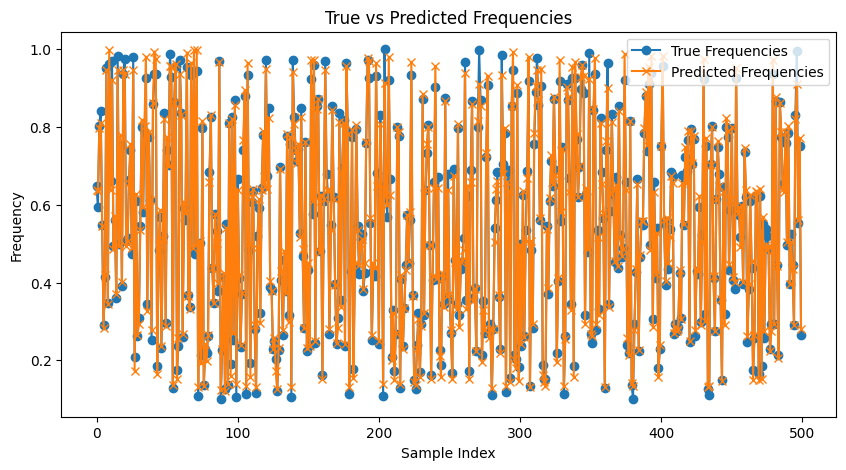

In [10]:
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(y_test.numpy(), label="True Frequencies", marker='o')
plt.plot(y_pred_test.numpy(), label="Predicted Frequencies", marker='x')
plt.title("True vs Predicted Frequencies")
plt.xlabel("Sample Index")
plt.ylabel("Frequency")
plt.legend()
plt.show()

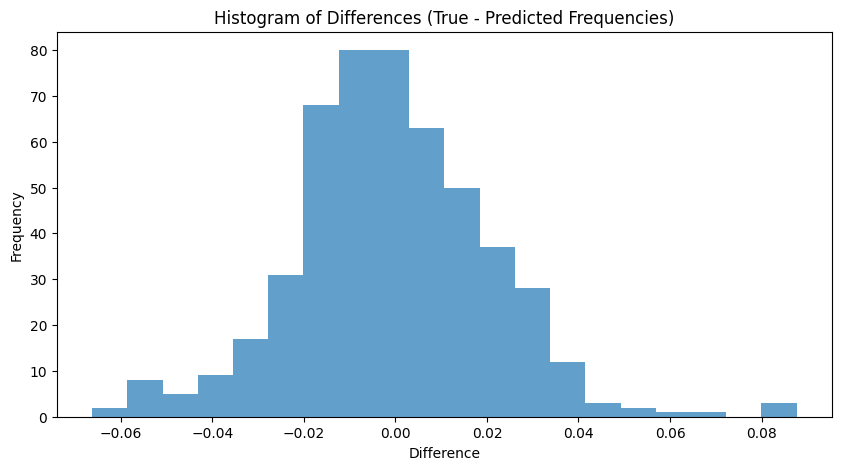

In [11]:
diffs = y_test - y_pred_test
# histogram of the differences
plt.figure(figsize=(10, 5))
plt.hist(diffs.numpy(), bins=20, alpha=0.7)
plt.title("Histogram of Differences (True - Predicted Frequencies)")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.show() 

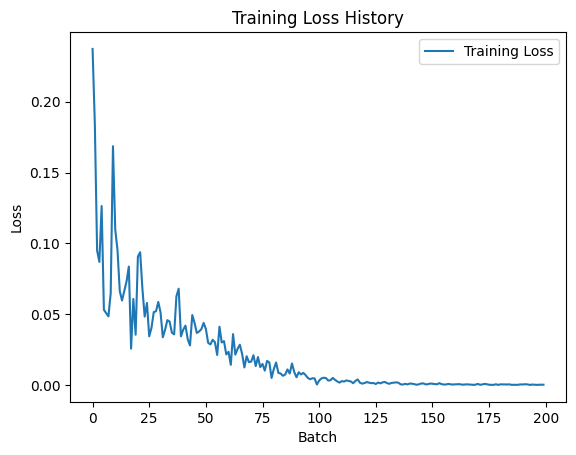

In [12]:
plt.plot(loss_hist, label="Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.show()


In [13]:
params_hist_nice = {
    key: np.array([i[key].detach().numpy() for i in params_hist])
    for key in params_hist[0].keys()
}
print(params_hist_nice.keys())

dict_keys(['positions', 'local_pulses_omega_1', 'local_pulses_delta_1', 'global_pulse_omega_1', 'global_pulse_delta_1', 'global_pulse_omega_2', 'global_pulse_delta_2', 'global_pulse_duration', 'local_pulse_duration', 'embed_pulse_duration', 'conv_params', '0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias'])


In [14]:
positions_hist = np.array([i["positions"].detach().numpy() for i in params_hist])
local_pulses_omega_1_hist = np.array([i["local_pulses_omega_1"].detach().numpy() for i in params_hist])
local_pulses_delta_1_hist = np.array([i["local_pulses_delta_1"].detach().numpy() for i in params_hist])

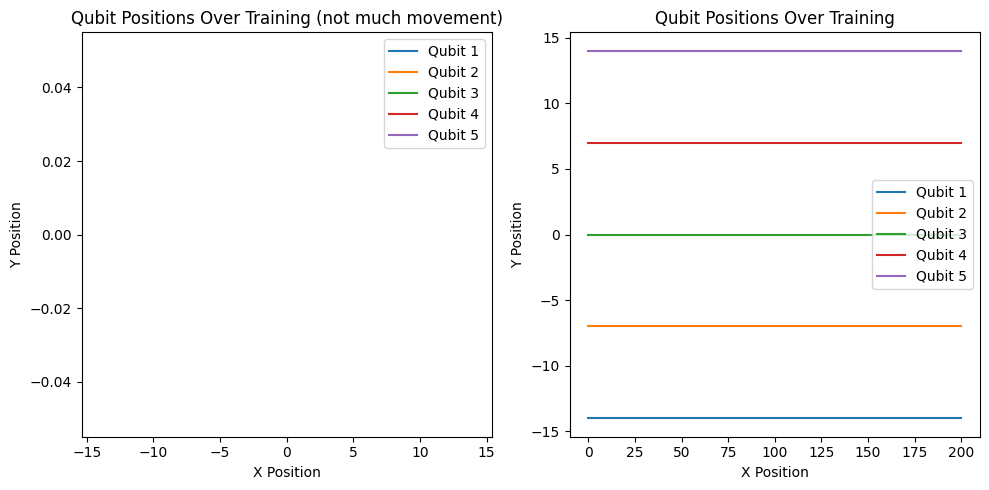

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
for qubit in range(positions_hist.shape[1]):
    plt.plot(positions_hist[:, qubit, 0], positions_hist[:, qubit, 1], label=f"Qubit {qubit+1}")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Qubit Positions Over Training (not much movement)")
plt.legend()
plt.sca(axs[1])
# only first qubit
plt.plot(positions_hist[:, 0, 0], label="Qubit 1")
plt.plot(positions_hist[:, 1, 0], label="Qubit 2")
plt.plot(positions_hist[:, 2, 0], label="Qubit 3")
plt.plot(positions_hist[:, 3, 0], label="Qubit 4")
plt.plot(positions_hist[:, 4, 0], label="Qubit 5")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Qubit Positions Over Training")
plt.legend()
plt.tight_layout()  
plt.show()  

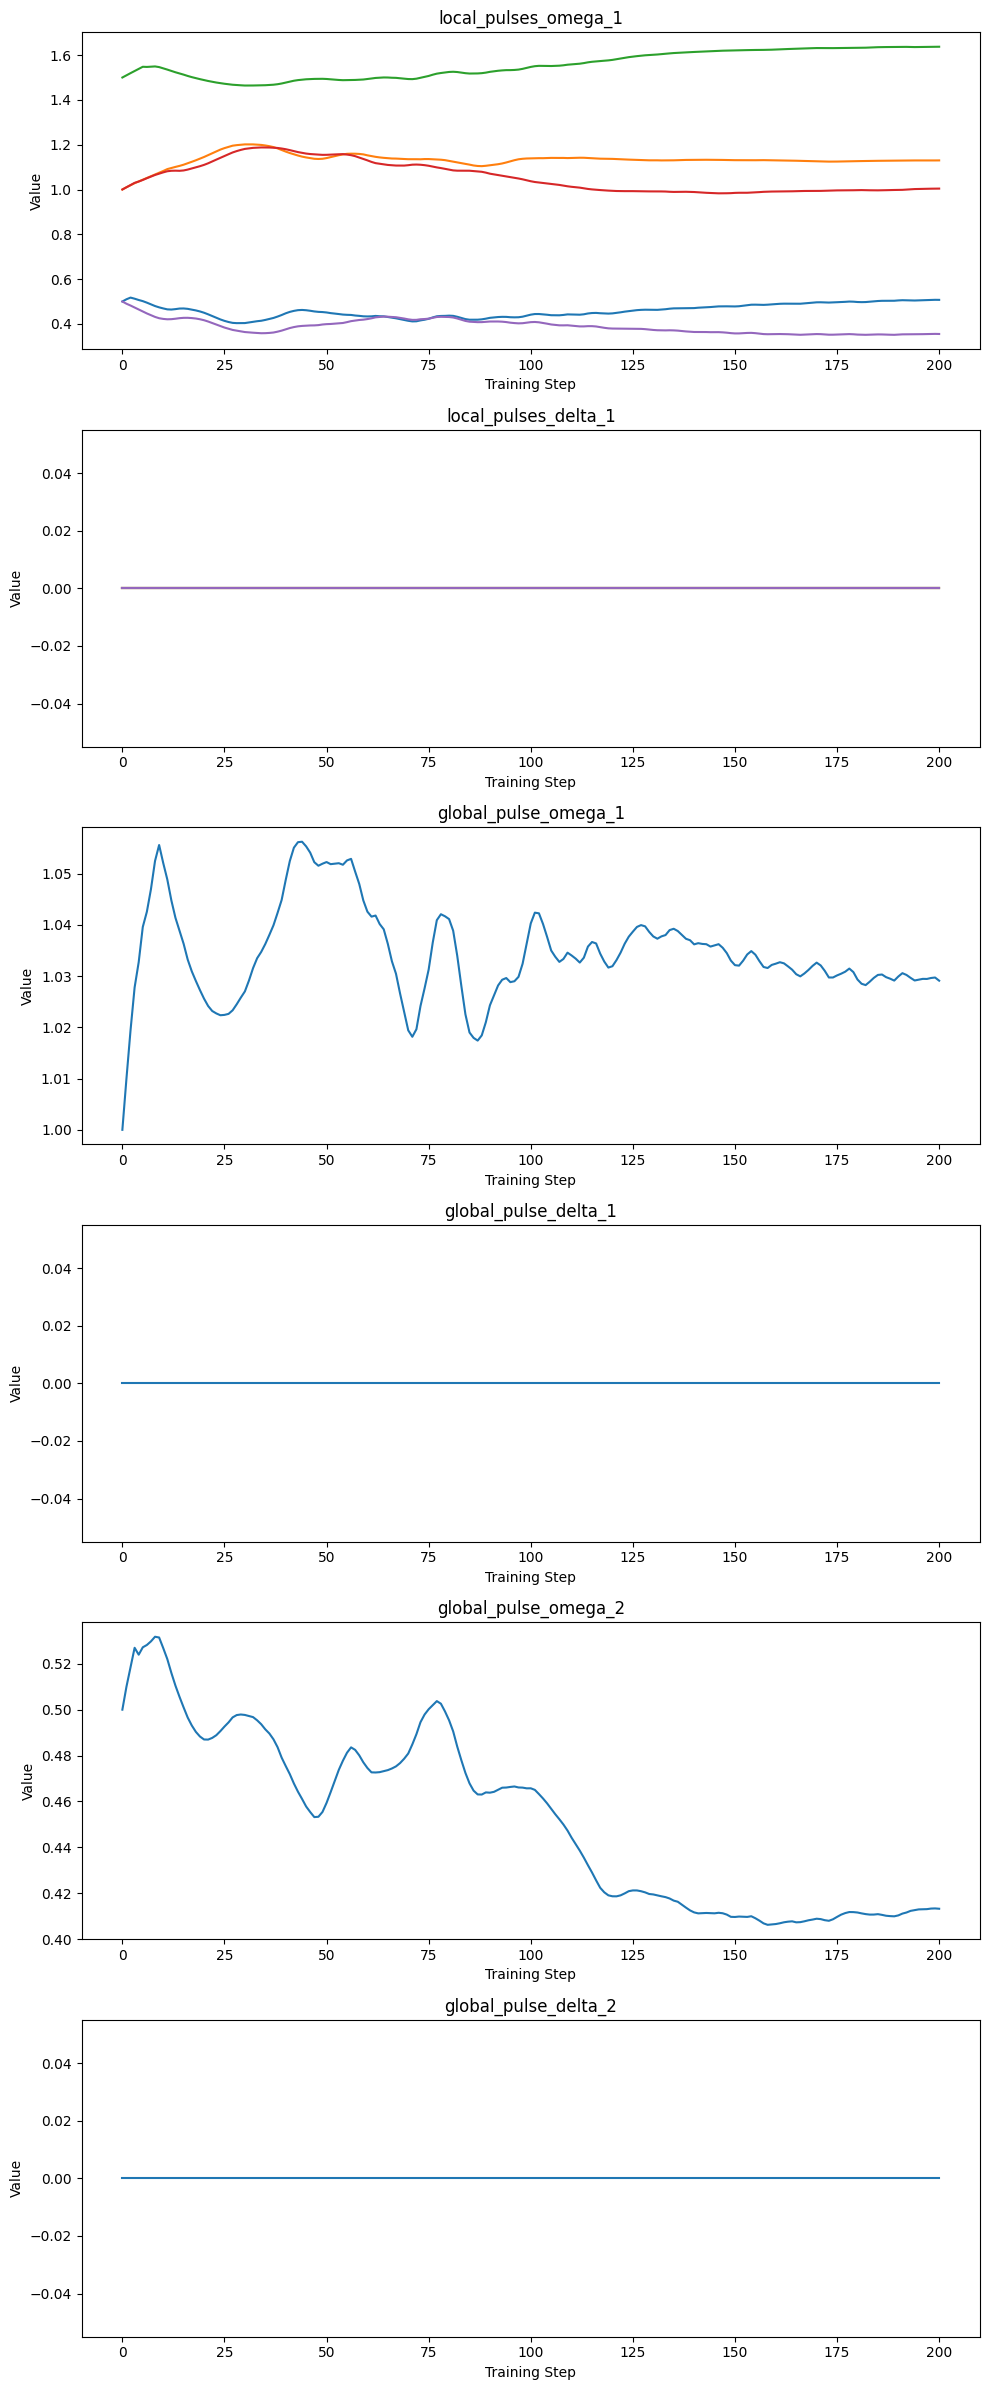

In [16]:
plot_keys = ['local_pulses_omega_1', 'local_pulses_delta_1', 'global_pulse_omega_1', 'global_pulse_delta_1', 'global_pulse_omega_2', 'global_pulse_delta_2']
fig, axs = plt.subplots(len(plot_keys), 1, figsize=(10, 4 * len(plot_keys)))
for i, key in enumerate(plot_keys):
    axs[i].plot(params_hist_nice[key])
    axs[i].set_title(key)
    axs[i].set_xlabel("Training Step")
    axs[i].set_ylabel("Value")
plt.tight_layout()
plt.show()  

In [17]:
import pickle

# number of learned parameters, i.e. with require_grad=True
NAHEA_CNN.train()
# number of parameters
n_params = sum(v.numel() for p, v in NAHEA_CNN.parameters().items() if v.requires_grad)
print(f"Number of trainable parameters: {n_params}")
# save training history
os.makedirs("losses_hist", exist_ok=True)
with open("losses_hist/NAHEA_CNN_train_hist.pickle", "wb") as f:
    pickle.dump(
        {
            "loss_hist": loss_hist,
            "params_hist": params_hist,
            "hparams": hparams,
            loss_test.item(): "test_loss",
            "n_learned_parameters": n_params,
        },
        f,
    )

Number of trainable parameters: 160
